In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

### Loading the Data

In [2]:
def load_data(data_dir, labels_map):
    data = []
    labels = []
    
    for sub_dir in os.listdir(data_dir):
        sub_dir_path = os.path.join(data_dir, sub_dir)
        label = labels_map[sub_dir] # each breed
  
        for image_filename in os.listdir(sub_dir_path):
            image_path = os.path.join(sub_dir_path, image_filename)
            image = cv2.imread(image_path)
            if image is not None:
                image_gray = image / 255.0 # gray scaling
                image_resized = cv2.resize(image_gray, (64, 64)) # resizing
                data.append(image_resized)
                labels.append(label)
        print(f"{sub_dir} loading process is done")
    
    return data, labels

In [3]:
data_dir = r'Breed-classification-dataset\Data'

# Map contains all labels
labels_map = {sub_dir: label for label, sub_dir in enumerate(os.listdir(data_dir))}

data, data_labels = load_data(data_dir=data_dir, labels_map=labels_map)

data, labels = np.array(data), np.array(data_labels)

print('\nLoaing process is done')

abyssinian loading process is done
american_bulldog loading process is done
american_pit_bull_terrier loading process is done
basset_hound loading process is done
beagle loading process is done
bengal loading process is done
birman loading process is done
bombay loading process is done
boxer loading process is done
british_shorthair loading process is done
chihuahua loading process is done
egyptian_mau loading process is done
english_cocker_spaniel loading process is done
english_setter loading process is done
german_shorthaired loading process is done
great_pyrenees loading process is done
havanese loading process is done
japanese_chin loading process is done
keeshond loading process is done
leonberger loading process is done
maine_coon loading process is done
miniature_pinscher loading process is done
newfoundland loading process is done
persian loading process is done
pomeranian loading process is done
pug loading process is done
ragdoll loading process is done
russian_blue loading 

### Creating DataFrame

In [7]:
df = pd.DataFrame({'images': list(data), 'labels': labels})
df_shuffled = df.sample(frac=1).reset_index(drop=True)

df_shuffled.head()

,images,labels
0,"[[[0.3519569546568627, 0.4617244944852941, 0.6...",26
1,"[[[0.17688036151960784, 0.2672506893382353, 0....",8
2,"[[[0.02034313725490196, 0.0125, 0.0125], [0.02...",1
3,"[[[0.9921568627450981, 1.0, 1.0], [0.992156862...",7
4,"[[[0.6560968137254902, 0.6012369791666667, 0.5...",28


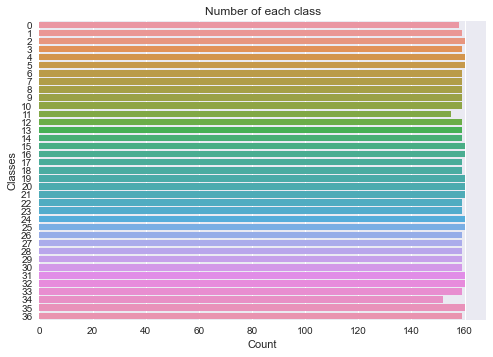

In [8]:
ax = sns.countplot(y=df_shuffled['labels'], data=df_shuffled)

# Annotating the count of each class
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_y() + p.get_height() / 2., p.get_width()),
                ha='center', va='bottom', fontsize=12, color='black')


plt.xlabel('Count')
plt.ylabel('Classes')
plt.title('Number of each class')

plt.show()

### Data preprocessing- Squezing, PCA, Scaling

In [9]:
m = df_shuffled.shape[0]
n_x = 12288
X = np.ndarray((m, n_x), dtype=np.float64)
y = np.zeros((m, 1))

for index, row in df_shuffled.iterrows():
    image, label = row['images'], row['labels']
    X[index, :] = np.squeeze(image.reshape((n_x, 1)))
    y[index, 0] = label
    
squeezed_data = pd.DataFrame(data=X)
target = y

squeezed_data

,0,1,2,3,4,5,6,7,8,9,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,0.351957,0.461724,0.605346,0.395938,0.488897,0.578652,0.461391,0.563099,0.642393,0.538542,...,0.155177,0.098253,0.048367,0.185319,0.086185,0.055951,0.118308,0.059729,0.040124,0.112697
1,0.176880,0.267251,0.480679,0.258824,0.367716,0.624468,0.313725,0.434967,0.682135,0.273964,...,0.488180,0.404691,0.427035,0.470500,0.408481,0.419755,0.462893,0.412981,0.417412,0.472313
2,0.020343,0.012500,0.012500,0.024394,0.016551,0.016551,0.019576,0.011733,0.011733,0.034116,...,0.087465,0.102202,0.117889,0.121809,0.135811,0.151497,0.155419,0.146127,0.164142,0.168064
3,0.992157,1.000000,1.000000,0.992157,1.000000,1.000000,0.992157,1.000000,1.000000,0.707230,...,0.990395,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.656097,0.601237,0.593490,0.661072,0.612841,0.593616,0.415054,0.403554,0.395979,0.461386,...,0.750532,0.829044,0.774533,0.727539,0.815851,0.758008,0.723859,0.793382,0.742839,0.711466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5879,0.358088,0.300069,0.137906,0.364009,0.279626,0.130844,0.384184,0.299755,0.152298,0.394616,...,0.374127,0.371561,0.474510,0.392279,0.358035,0.478516,0.387002,0.336412,0.510432,0.398506
5880,0.007843,0.003922,0.018239,0.004290,0.000369,0.016055,0.003922,0.000000,0.007843,0.005607,...,0.051991,0.099555,0.091055,0.102163,0.054229,0.040138,0.088391,0.017699,0.012449,0.027605
5881,0.805058,0.750156,0.754078,0.844196,0.796159,0.796648,0.905497,0.850841,0.854395,0.909804,...,0.827035,0.735864,0.786354,0.817849,0.740408,0.798621,0.832689,0.749215,0.793761,0.822948
5882,0.898039,0.909804,0.901961,0.895772,0.907537,0.899694,0.897978,0.909743,0.901900,0.894178,...,0.976470,0.960784,0.980392,0.972549,0.960784,0.980392,0.976471,0.956863,0.976471,0.972549


##### PCA

In [10]:
pca = PCA(n_components=0.95)
data_pca = pca.fit_transform(squeezed_data)

##### Scaling

In [11]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_pca)

### Train Test Split

In [12]:
# X, y = df_shuffled['images'], df_shuffled['labels']

train_size, val_size, test_size = 0.75, 0.15, 0.1

x_train, x_test, y_train, y_test = train_test_split(data_scaled, target, test_size=1 - train_size, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_size/(test_size + val_size))

### Finding Best Parameters

Using the extensive param_grid took a long time- I skipped it due to lack of time

In [13]:
#param_grid = {'n_neighbors': [3,5,7,9],
 #            'weights': ['uniform', 'distance'],
  #           'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
   #           metric': ['euclidean', 'manhattan', 'chebyshev']}

param_grid = {'n_neighbors': [3,5,7,9],
             'metric': ['euclidean', 'manhattan', 'chebyshev']}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train.ravel())

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': [3, 5, 7, 9]},
             scoring='accuracy')

In [14]:
best_params = grid_search.best_params_
print(best_params)
print(grid_search.best_score_)

knn_best = grid_search.best_estimator_
knn_best.fit(x_train, y_train)

{'metric': 'chebyshev', 'n_neighbors': 3}
0.04191775615493461


KNeighborsClassifier(metric='chebyshev', n_neighbors=3)

### Model Evaluation

In [15]:
val_accuracy = knn_best.score(x_val, y_val)
print(f"Val accuracy: {val_accuracy:.2f}")

Val accuracy: 0.03


In [16]:
prediction = knn_best.predict(x_test)
predicted_labels = (prediction > 0.5).astype(int)

print(classification_report(y_true=y_test, y_pred=predicted_labels))

              precision    recall  f1-score   support

         0.0       0.05      0.46      0.08        13
         1.0       0.04      0.86      0.07        21
         2.0       0.00      0.00      0.00        16
         3.0       0.00      0.00      0.00        19
         4.0       0.00      0.00      0.00        14
         5.0       0.00      0.00      0.00        17
         6.0       0.00      0.00      0.00        15
         7.0       0.00      0.00      0.00        20
         8.0       0.00      0.00      0.00        15
         9.0       0.00      0.00      0.00        15
        10.0       0.00      0.00      0.00        22
        11.0       0.00      0.00      0.00        15
        12.0       0.00      0.00      0.00        23
        13.0       0.00      0.00      0.00        14
        14.0       0.00      0.00      0.00        14
        15.0       0.00      0.00      0.00        20
        16.0       0.00      0.00      0.00         8
        17.0       0.00    